# pre-trained model
[참고](https://deep-learning-study.tistory.com/476)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load pre-trained model

In [2]:
# load resnet18 with the pre-trained weights
from torchvision import models
import torch

resnet18_pretrained = models.resnet18(pretrained=True)

print(resnet18_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Library import

In [3]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

import gzip
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 이미지 추출, 이미지 출력, 라벨 list 생성 함수
[함수 인자 입력 순서](https://naon.me/posts/til18)

In [4]:
def extract_imgs(n, train = True):
    if train:
        imgs = gzip.open("train-images-idx3-ubyte.gz", 'r')
    else:
        imgs = gzip.open("t10k-images-idx3-ubyte.gz", 'r')
    
    img_size = 28
    num_imgs = n
    
    imgs.read(16) # 꼭 있어야 하는 코드였다. 출력을 위한게 아니었음.
    
    buf = imgs.read(img_size * img_size * num_imgs)
    data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
    data = data.reshape(num_imgs, img_size, img_size, 1)
    
    return data

def print_imgs(data, idx):
    img = np.asarray(data[idx]).squeeze()
    plt.imshow(img)
    plt.show()

def label_li(fin, train = True):
    li = []
    
    if train:
        labels = gzip.open("train-labels-idx1-ubyte.gz", 'r')
    else:
        labels = gzip.open("t10k-labels-idx1-ubyte.gz", 'r')
    
    labels.read(8) # 꼭 있어야 하는 코드였다. 출력을 위한게 아니었음.
    
    for i in range(0, fin): # start 늘린 수 만큼 뒤쪽 출력이 안됨.
        buf = labels.read(1)
        label = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)
        li.extend(list(label))
        
    return li

## 환경설정

In [5]:
import torch
import torch.nn as nn
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' # Arrange GPU devices starting from 0
os.environ['CUDA_VISIBLE_DEVICES'] = '2' # Set the GPU 2 to use
# 멀티 gpu 시스템은 하나의 GPU에서 코드가 실행되게 프로그래밍을 해도 모든 GPU에 메모리를 할당함.
# 따라서 2번 gpu만 사용하도록 코드를 짜 준 것.
## 돌아가는 것 확인 함.

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    #device = torch.device("cuda:0")
    print('Device:', device)
    print('Current cuda device:', torch.cuda.current_device()) # 현재 cuda가 사용할 GPU
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Device: cuda
Current cuda device: 0
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


## 하이퍼파라미터 튜닝

In [7]:
CFG = {
    'IMG_SIZE':28, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':1e-5, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SEED':41, #시드
}

### 모델의 재현성을 위한 random seed 고정

In [8]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 랜덤시드 고정
    torch.cuda.manual_seed(seed) # gpu 사용할 경우 랜덤시드 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(CFG['SEED'])

In [9]:
numdat = 10000
data = extract_imgs(numdat)
labels = label_li(numdat)

## train/val split

In [10]:
train_len = int(len(data)*0.75)
val_len = int(len(data)*0.25)

# train_data = data[:train_len]
# train_label = labels[:train_len]

# val_data = data[train_len:]
# val_label = labels[train_len:]

print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', val_len)

train set 길이 :  7500
vaildation set 길이 :  2500


## validation set

In [11]:
val_dt = data[train_len:]
val_lb = labels[train_len:]

In [12]:
## test cell
torch.tensor(val_dt.reshape(len(val_dt), 1, 28, 28)).float().shape

torch.tensor(val_lb)

torch.Size([2500, 1, 28, 28])

tensor([2, 3, 4,  ..., 6, 9, 7])

## test set

In [13]:
numdat = 10000
test_data = extract_imgs(numdat, train = False)
test_labels = label_li(numdat, train = False)

In [14]:
# data

## Custom Dataset

In [15]:
from torchvision import datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, train_mode = True, transforms = None): # 필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_list = img_list
        self.label_list = label_list
    
    def __getitem__(self, index): # index번째 data를 return
        img = self.img_list[index]
        img = np.asarray(data[index]).squeeze() # 추가해준 처리
        ## Get image data
#         print(img_path)
#         image = cv2.imread(img) # 이미 읽어온 이미지라서 이 코드 필요 없음.
#         print(image) # numpy 배열
        
        if self.transforms is not None:
            img = self.transforms(img)
            #flattened_img = img.flatten().float() # 2차원 이미지를 1차원으로 변환
        
        if self.train_mode:
            label = self.label_list[index]
            return img, label
        else:
            return img
        
    def __len__(self): # 길이 return
        return len(self.img_list)

## transform

In [16]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), # Numpy arr에서 PIL 이미지로
#     transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), # 이미지 사이즈 변형
    transforms.ToTensor()#, # 이미지 데이터를 tensor로
#     transforms.Normalize(mean = (0.5,), std = (0.5,)) # 이미지 정규화 (원소 3개짜리는 색이 있는 이미지일 경우에만, MNIST는 색 없는 이미지이므로 사용하지 않음.)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), # size 다 동일하므로 resize는 필요 없음
    transforms.ToTensor()#,
#     transforms.Normalize(mean = (0.5,), std = (0.5,)) ## 채널 별 정규화 (원소 3개짜리는 색이 있는 이미지일 경우에만, MNIST는 색 없는 이미지이므로 사용하지 않음.)
])

In [17]:
# image = Image.open(self.file_path_list[idx]) # 해당 인덱스에 맞는 image 추출
#         tensor_image = self.PIL2tensor(image) # PIL로 읽은 이미지를 torch tensor형으로 변환
#         flattened_image = tensor_image.flatten().float()

## dataloader

In [18]:
## CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(data[:train_len], labels[:train_len], train_mode = True, transforms = train_transform)
## 만든 train dataset을 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 0)

## validation에서도 적용
val_dataset = CustomDataset(data[train_len:], labels[train_len:], train_mode = True, transforms = test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 0)

In [19]:
list(train_dataset)[0][0].shape
## mnist_data 코드로 불러왔을 때처럼의 형태를 띠어야함.
## 그 형태: torch.Size([1, 28, 28])

torch.Size([1, 28, 28])

# output layer를 현재 data에 맞게 수정합니다.

In [20]:
# change the output layer to 10 classes
num_classes = 10
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = torch.nn.Linear(num_ftrs, num_classes)

# device = torch.device('cuda:0')
resnet18_pretrained.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
resnet18_pretrained.conv1 # 맨 앞이 3인걸 보니 이건 colored data용 모델임.

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#### flatten을 수행하지 않은 8th try의 model에서 input이 1이었음을 고려하여, 해당 모델 input도 1로 바꿔주기로 한다.

In [22]:
kernel_s = resnet18_pretrained.conv1.kernel_size
strd = resnet18_pretrained.conv1.stride
padd = resnet18_pretrained.conv1.padding
bs = resnet18_pretrained.conv1.bias
in_c = resnet18_pretrained.conv1.in_channels
out_c = resnet18_pretrained.conv1.out_channels

## 위의 fc layer를 변경하는 것과 같은 방식으로 하려면
# resnet18_pretrained.conv1 = torch.nn.Conv2d(1, out_c, kernel_s, strd, padd, bs)

## 보다 나은 방식은 이것임
# resnet18_pretrained.conv1.in_channels = 1
# resnet18_pretrained.conv1.in_channels

## ------------------------------------------------------ 위 방법이 안먹힘.
resnet18_pretrained.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
resnet18_pretrained.conv1.kernel_size
resnet18_pretrained.conv1.stride
resnet18_pretrained.conv1.padding

(7, 7)

(2, 2)

(3, 3)

## 모델 요약본을 출력하여 잘 불러왔는지 확인해보겠습니다.

In [24]:
# %pip install torchsummary

You should consider upgrading via the '/home/dacon/anaconda3/envs/geonu/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
# get the model summary
from torchsummary import summary
summary(resnet18_pretrained.to(device=device), input_size=(1, 7, 7), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           3,136
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

## 첫 번째 레이어의 가중치를 시각화하여 확인해보겠습니다.

In [25]:
import torchvision
import matplotlib.pyplot as plt

# visualize the filters of the first CNN layer
for w in resnet18_pretrained.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1) # padding이 있어서 65된 것 같음.

########### img show, x_grid의 size문제가 아님. show라는 모듈이 따로 없는 것이 문제임.
## 아래서 show 함수 찾아다 실행하고 나면 img 시각화 원하는대호 가능.

torch.Size([64, 1, 7, 7])


## 원했던 img 시각화
[show 함수 참고](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html)

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
# plt.figure(figsize=(100, 100))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        _ = axs[0, i].imshow(np.asarray(img))
        _ = axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
#     plt.savefig('test.png', dpi = 200)

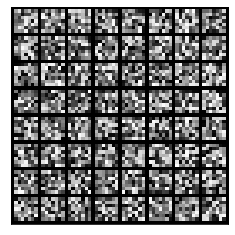

In [27]:
show(x_grid)

## 이 아래 cell 시각화를 원한게 아님. 모든 채널에 대한 시각화를 원한 것임.

3

'imshow 안에 들어갈 data shape:(65, 65)'

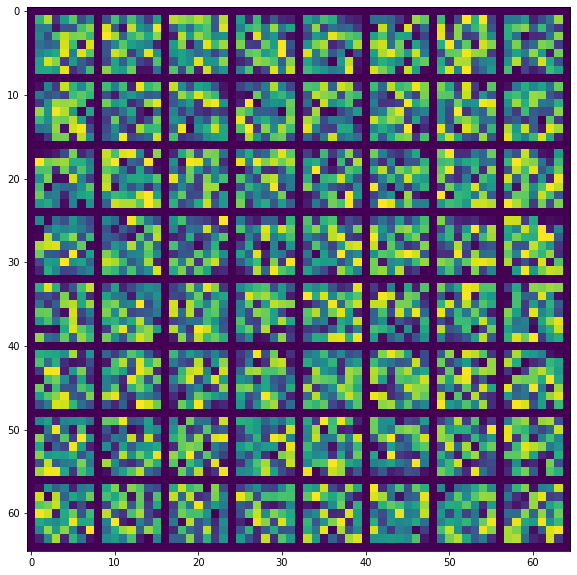

In [28]:
import numpy as np
_ = plt.figure(figsize=(10, 10))
x_grid.shape[0]
img = np.asarray(x_grid[0]).squeeze() # np.asarray(x_grid[0].cpu().detach()) # 이것도 같음.

f'imshow 안에 들어갈 data shape:{img.shape}'
_ = plt.imshow(img)

## 하이퍼파라미터 튜닝

In [29]:
CFG = {
    'IMG_SIZE':28, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':1e-5, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SEED':41, #시드
}

## loss function, optimizer 정의

In [31]:
model = resnet18_pretrained.to(device=device)
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

In [32]:
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 235


## train validation 따로 하는 ver

In [33]:
losses = []
for epoch in range(CFG['EPOCHS']):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # loss
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    loss = avg_cost / len(train_loader)
    losses.append(loss)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 2.02064109
[Epoch:    2] cost = 1.23543751
[Epoch:    3] cost = 0.853463829
[Epoch:    4] cost = 0.634583473
[Epoch:    5] cost = 0.498769343
[Epoch:    6] cost = 0.399092764
[Epoch:    7] cost = 0.337913841
[Epoch:    8] cost = 0.282703102
[Epoch:    9] cost = 0.23869884
[Epoch:   10] cost = 0.222204894
[Epoch:   11] cost = 0.182668045
[Epoch:   12] cost = 0.154571846
[Epoch:   13] cost = 0.139870703
[Epoch:   14] cost = 0.119070441
[Epoch:   15] cost = 0.105810717
[Epoch:   16] cost = 0.0933045447
[Epoch:   17] cost = 0.0852235183
[Epoch:   18] cost = 0.0693085864
[Epoch:   19] cost = 0.0648128763
[Epoch:   20] cost = 0.0601171181
[Epoch:   21] cost = 0.0525147207
[Epoch:   22] cost = 0.0513720624
[Epoch:   23] cost = 0.0458897874
[Epoch:   24] cost = 0.03714123
[Epoch:   25] cost = 0.0359920226
[Epoch:   26] cost = 0.0359422714
[Epoch:   27] cost = 0.0295815952
[Epoch:   28] cost = 0.0334782191
[Epoch:   29] cost = 0.0255688652
[Epoch:   30] cost = 0.0255137794


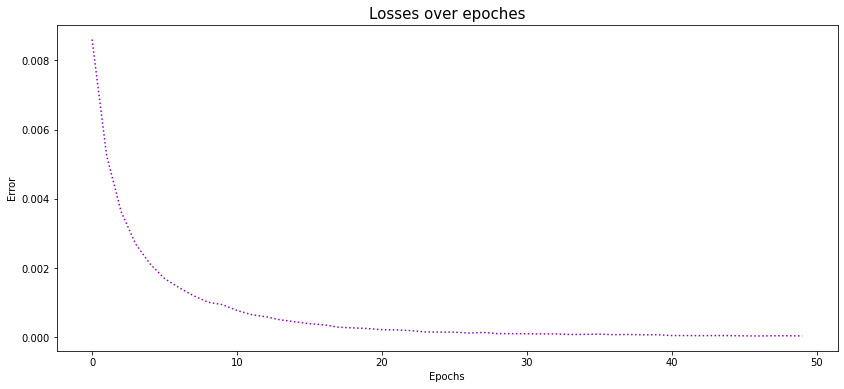

In [34]:
# 전체 loss 에 대한 변화량 시각화
_ = plt.figure(figsize=(14, 6))
_ = plt.plot(losses[:100], c='darkviolet', linestyle=':')

_ = plt.title('Losses over epoches', fontsize=15)
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Error')
_ = plt.show()

# loss는 확 줄어들어서 바닥으로 수렴하는게 아름다운 모습임

## validation set score 확인

In [35]:
with torch.no_grad():
    X_test = torch.tensor(val_dt.reshape(len(val_dt), 1, 28, 28)).float().to(device)
    Y_test = torch.tensor(val_lb).to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

## 따로 ver
# 0.9391999840736389

## 같이 ver


Accuracy: 0.9391999840736389


## test set score 확인

In [36]:
with torch.no_grad():
    X_test = torch.tensor(test_data.reshape(len(test_data), 1, 28, 28)).float().to(device)
    Y_test = torch.tensor(test_labels).to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

## 따로 ver
# 0.9506999850273132

## 같이 ver


Accuracy: 0.9506999850273132
